# Monte Carlo LunarLander

Tabular Monte Carlo method to solve OpenAI GYM LunarLander-v2: https://gym.openai.com/envs/LunarLander-v2/

You can find more about this algorithm in Sutton's book Reinforcement Learning: An introduction (Chapter 5) http://incompleteideas.net/book/the-book-2nd.html

---

## Importing packages

In [1]:
import numpy as np
import gym
import random
import math

## Create the environment

In [2]:
def create_env():
    return gym.make('LunarLander-v2')
    #env.render()

## Environment preview

In [3]:
def env_preview(env):
    env.reset()
    for dummy in range(100):
        env.render()
        state, reward, done, info = env.step(env.action_space.sample())
        if done:
            break
    env.close()

## Understanding the environment

In [4]:
def show_action_and_env_space(env):
    # Action space and environment space
    print("env.action_space", env.action_space)
    print("env.observation_space", env.observation_space)
    print("env.observation_space.high", env.observation_space.high)
    print("env.observation_space.low", env.observation_space.low)

## Buckets
We need to discretize the environment values (observation vector); to do this, we are going to use buckets for each dimension of the observation vector. If the real value of the first dimension of the observation vector is in $[a,b]$ and if the number of buckets for that dimension is $n$, we are going to interpolate that real value into an integer in $[0,n-1]$.

In [5]:
def set_buckets_and_actions():
    number_of_buckets = (5,5,5,5,5,5,2,2) #buckets in each dimension
    number_of_actions = env.action_space.n
    
    #Creating a 2-tuple with the original bounds of each dimension
    state_value_bounds = list(zip(env.observation_space.low,env.observation_space.high))
    
    #New bound values for each dimension
    state_value_bounds[0] = [-1,1]      #Position x
    state_value_bounds[1] = [-1,1]    #Position y
    state_value_bounds[2] = [-1,1]        #vel x
    state_value_bounds[3] = [-1,1]    #vel y
    state_value_bounds[4] = [-1,1]        #angle
    state_value_bounds[5] = [-1,1]        #angular vel
    state_value_bounds[6] = [0,1]
    state_value_bounds[7] = [0,1]
    
    return number_of_buckets, number_of_actions, state_value_bounds
    
    

In [6]:
def bucketize(state):
    bucket_indexes = []
    for i in range(len(state)):
        if state[i] <= state_value_bounds[i][0]:
            bucket_index = 0
        elif state[i] >= state_value_bounds[i][1]:
            bucket_index = number_of_buckets[i] - 1
        else:
            bound_width = state_value_bounds[i][1] - state_value_bounds[i][0]
            offset = (number_of_buckets[i]-1) * state_value_bounds[i][0]/bound_width
            scaling = (number_of_buckets[i]-1) / bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indexes.append(bucket_index)
    return tuple(bucket_indexes)

## Create the Q-table

In [7]:
def initialize_q_table():
    return np.zeros(number_of_buckets + (number_of_actions,))

## Create Returns_table

In [8]:
def initialize_visits_table():
    return np.zeros(number_of_buckets + (number_of_actions,))

In [9]:
def decay_function(episode):
    return max(min_epsilon, min(max_epsilon, 1.0 - 
                              math.log10((episode + 1) / (total_train_episodes*0.1))))

In [10]:
def choose_action(q_table, bucket_state, epsilon):
    if (np.random.random() <= epsilon):
        #print("random")
        return env.action_space.sample() #Exploration
    else:
        #print("greedy")
        return np.argmax(q_table[bucket_state]) #Eplotation

In [11]:
# ******* Generate an episode following pi: S0, A0, R1, ...S_T-1,A_T-1,R_T
def Generate_episode(epsilon, q_table, max_env_steps):
    # Control variables
    total_reward = 0
    done = False
        
    trayectory = []
        
    # Initialize S
    # Reset the environment getting the initial state
    bucket_state = bucketize(env.reset())

    # Loop for each step of episode:
    for step in range(max_env_steps):
            #print("step ", step)

        # Choose A from S using a soft policy derived from Q (e.g., epsilon-greedy)
        action = choose_action(q_table, bucket_state, epsilon)
            #print(q_table[bucket_state])
            #print("action ", action)

        # Take the action A, observe R, S'
        new_state, reward, done, info = env.step(action)
        bucket_new_state = bucketize(new_state)
            #print("reward ", reward)
            
        trayectory.append([bucket_state, action, reward])
            
        # new_state is now the current state
        bucket_state = bucket_new_state

        total_reward += reward

        # if done, finish the episode
        if done:
            break
    
    return trayectory, total_reward

---

# The Monte Carlo algorithm

* Initialize $Q(s,a) \in \mathbb{R}$ arbitrarily ($Q(S,A) = 0$, for all $S,A$ in this case)
* $Returns(s,a) \longleftarrow$ empty list for all $S, A$
* Loop for each episode:
    * Generate an episode following $\pi$: $S_0, A_0, R_1, ..., S_{T-1}, A_{T-1}, R_T$
    * $G \longleftarrow 0$
    * Loop for each step of episode, $t=T-1, T-2, ..., 0$:
        * $G \longleftarrow \gamma G + R_{t+1}$
        * Unless the pair $S_t, A_t$ appears in $S_0, A_0, S_1, A_1, ..., S_{t-1}, A_{t-1}$:
            * Append $G$ to $Returns(S_t,A_t)$
            * $Q(S_t,A_t)$ $\longleftarrow$ average($Returns(S_t,A_t)$)
            * $A* \longleftarrow argmax_aQ(S_t,a)$
            * For all $a \in A(S_t)$:
                * if $a = A*: \pi (a|S_t) \longleftarrow 1 - \epsilon + \epsilon / A(S_t)$
                * else if $a \neq A*: \pi (a|S_t) \longleftarrow \epsilon / A(S_t)$
                

In [12]:
def Monte_Carlo():
    # ******* Initialize 𝑄(s,a) arbitrarily.
    q_table = initialize_q_table()
    #print("Q_Table shape: ", q_table.shape)
    
    # ******* Initialize Returns(s,a) empty list
    # initialize visits_counter instead (for incremental implementation of the average)
    visits_counter = initialize_visits_table()
    
    rewards = []
    
    max_env_steps = env._max_episode_steps   #1000 in LunarLander
    #print("Max env steps: ", max_env_steps)
    

    
    # ******* Loop for each episode:
    for episode in range(total_train_episodes):
        #print("\n\n ***Episode*** ", episode)
        
        # ******* Generate an episode following pi: S0, A0, R1, ...S_T-1,A_T-1,R_T
        #Update epsilon
        epsilon = decay_function(episode)
        #print("Epsilon ", epsilon)
        trayectory ,total_reward = Generate_episode(epsilon, q_table, max_env_steps)
        
        # ******* G <-- 0
        G = 0
        
        
        # ******* Loop for each step of episode: t = T-1, T-2, ..., 0
        for t in reversed(range(len(trayectory))):
            #print("\n step", t)
            s_t, a_t, r_t = trayectory[t]
            # ******* G <-- gamma*G + R_{t+1}
            G = gamma*G + r_t
            #print("G ", G)
            
            # ******* Unless the pair S_t,A_t appears in S_0,A_0,R_1, ...,S_{t-1},A_{t-1}: 
            if not [s_t, a_t] in [[x[0], x[1]] for x in trayectory[0:t]]:
                #print("YES First visit ", s_t, a_t)
                
                # ******* Append G to Returns(S_t,A_t)
                # ******* Q(S_t,A_t) <-- average(Returns(S_t,A_t))
                # Using incremental implementation: Q(S_t,A_t)= Q_n <-- Q_n + (1/n)*(G_n - Q_n)
                visits_counter[s_t][a_t] += 1
                #print("visits_counter ", visits_counter[s_t][a_t])
                #print("old Q value ", q_table[s_t][a_t])
                q_table[s_t][a_t] += (G - q_table[s_t][a_t]) / visits_counter[s_t][a_t]
                #print("new Q value ", q_table[s_t][a_t])
            #else: print("NO first visit ", s_t, a_t)
        
                  
        #print("total_reward ", total_reward)
        
        if episode % 50 == 0:
            rewards.append(total_reward)
            print("Episode {}, epsilon {:5.4f}, reward {:6.2f}".format(episode,epsilon,total_reward))  
    
    rewards.append(total_reward)
    print("Episode {}, epsilon {:5.4f}, reward {:6.2f}".format(episode,epsilon,total_reward))
    return q_table, rewards

---

## Getting Q-Learning training plots 

#### Running Q-Learning algorithm n times

In [ ]:
n_times = 5
total_train_episodes = 10000
gamma = 0.99                     
max_epsilon = 1.0
min_epsilon = 0.01   

env = create_env()
#env_preview(env)
#show_action_and_env_space(env)
number_of_buckets, number_of_actions, state_value_bounds = set_buckets_and_actions()

MC_tables = []
MC_rewards = []

for number in range(n_times):
    print("\n ********** Training number ", number)
    q_table,rewards = Monte_Carlo()
    MC_tables.append(q_table)
    MC_rewards.append(rewards)

#### Saving average reward and Q-tables

In [14]:
MC_mean = np.mean(np.array(MC_rewards),axis=0)
#print(MC_mean.shape)
np.save('MC_mean', MC_mean)
np.save('MC_tables', MC_tables)

#### Plotting Q-Learning rewards

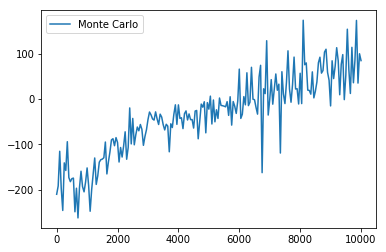

In [15]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

x = np.linspace(0, total_train_episodes, MC_mean.size)
plt.plot(x, MC_mean, label='Monte Carlo')

# Add a legend
plt.legend()

# Show the plot
plt.show()

---

# Testing


#### Testing Q(s,·) values for a given initial state s

In [17]:
#env = create_env()
q_tables = np.load('MC_tables.npy')
q_table = q_tables[0]

number_of_buckets, number_of_actions, state_value_bounds = set_buckets_and_actions()
bucket_state = bucketize(env.reset())

print("State ", bucket_state)
print("Q(s,·) ", q_table[bucket_state])

State  (2, 4, 3, 3, 2, 2, 0, 0)
Q(s,·)  [-46.15959409 -21.25496133 -44.52908797 -49.35687673]


#### Testing LunarLander with the learned Q-Table

In [18]:
#env = create_env()
total_test_episodes = 10
q_tables = np.load('MC_tables.npy')
q_table = q_tables[0]
rewards = []
max_env_steps = env._max_episode_steps
number_of_buckets, number_of_actions, state_value_bounds = set_buckets_and_actions()

# ******* Loop for each episode:
for episode in range(total_test_episodes):
    #print("***Episode*** ", episode)
    
    # Control variables
    total_rewards = 0
    done =  False
    
    # ******* Initialize S
    # Reset the environment getting the initial state
    bucket_state = bucketize(env.reset())
    
    # *******Loop for each step of episode:
    for step in range(max_env_steps):
        env.render()
        
        #******* Choose A from S using policy derived from Q (greedy in this case)
        action = np.argmax(q_table[bucket_state])
        #print(action)
        
        # ******* Take the action A, observe R, S'
        new_state, reward, done, info = env.step(action)
        bucket_new_state = bucketize(new_state)
        
        # new_state is now the current state
        bucket_state =  bucket_new_state
        
        total_rewards += reward
        
        if done:
            rewards.append(total_rewards)
            print("Score ", total_rewards)
            break
                
env.close()
print("\nAverage score " + str(sum(rewards)/total_test_episodes))

Score  -130.04434967846996
Score  263.1832594923769
Score  -35.38586349921573
Score  -26.58173671514035
Score  175.67293461255667
Score  -321.72136296741445
Score  -27.262075919377367
Score  218.37341111487225
Score  15.450789741070821
Score  0.3165793666875203

Average score13.200158554794632
